# Проект: Статистический анализ данных. Аналитика сервиса аренды самокатов GoFast 🛴

**Цель проекта:** Проведение иссследовательского и статистического анализа данных, которые могут помочь сервису проката самокатов GoFast вырасти.

**Ход исследования:**
1. Осуществим предобработку данных: найдем и по возможности устраним пропуски, а так же обработаем дубликаты.
2. Проведем исследовательский анализ данных: с помощью инструментов визуализации найдем взаимосвзязь некоторых парметров для пользователей и поездок.
3. Объединим данные и визуализируем информацию о расстоянии и времени поездок для пользователей обеих представленных категорий.
4. Подсчитаем выручку, которую приносит каждый пользователь.
5. Проверим гипотезы в целях помочь бизнесу увеличить количество пользователей с подпиской.
6. Решить несколько задач относительно распределений случайных величин.
7. Сформулировать выводы

**Содержание**<a id='toc0_'></a>    
  
1. [Загрузка данных](#toc1_)
                               
2. [Предобработка данных](#toc2_)
 
3. [Исследовательский анализ данных (EDA)](#toc3_)

4. [Объединение данных](#toc4_)
   
5. [Подсчет выручки](#toc5_)
    
6. [Проверка гипотез](#toc6_)
    
7. [Общий вывод](#toc7_)


Для начала импортируем все библиотеки, которые нам понадобятся в ходе исследования.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
from termcolor import colored
import os

## <a id='toc1_'></a>Загрузка данных [&#8593;](#toc0_)

Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы:

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

In [3]:
print(data_users.info())
data_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


In [4]:
print(data_rides.info())
data_rides

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


In [5]:
print(data_subscriptions.info())
data_subscriptions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Данные на первый взгляд выглядят целостно, без явных дефектов. Бросается в глаза - неправильный тип данных даты. Необходимо поменять его.

## <a id='toc2_'></a>Предобработка данных [&#8593;](#toc0_)

На этапе предобработки обработаем типы данных, пропущенные значения и дубликаты, а также добавим новый столбец с месяцами поездок.

1. Приведем столбец date к типу даты pandas.

In [6]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d') #Заменим тип данных в столбце с датами


2. Создадим новый столбец с номером месяца на основе столбца date.

In [7]:
data_rides['month'] = data_rides['date'].dt.month
print(data_rides.info())
data_rides.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB
None


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


Здесь проверим, за какой период имеются данные:



In [8]:
print(max(data_rides['date']), min(data_rides['date']))

2021-12-30 00:00:00 2021-01-01 00:00:00


Данные представлены за один 2021 год 

3. Проверим наличие пропущенных значений и дубликатов в датафреймах.

In [9]:
print(data_users.isna().sum(),'\n')
print(data_rides.isna().sum(),'\n')
print(data_subscriptions.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64 

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64 

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Пропусков нет. Теперь проверим датасеты на явные и неявные дубликаты:

In [10]:
data_users.duplicated().sum()

31

Уберем явные дубликаты в данном датасете:

In [11]:
data_users = data_users.drop_duplicates().reset_index()
print(data_users.info())
data_users.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              1534 non-null   int64 
 1   user_id            1534 non-null   int64 
 2   name               1534 non-null   object
 3   age                1534 non-null   int64 
 4   city               1534 non-null   object
 5   subscription_type  1534 non-null   object
dtypes: int64(3), object(3)
memory usage: 72.0+ KB
None


0

Было 1565 строк, стало 1534, следовательно, убрали 31 дубликат. 

Проверим на неявные дубликаты:

In [12]:
print(data_users['city'].unique(),'\n')
print(data_users['subscription_type'].unique(),'\n')

['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи'] 

['ultra' 'free'] 



Неявных дубликатов здесь нет.


Проверим остальные датафреймы подобным образом:

In [13]:
print(data_rides.duplicated().sum(),'\n')
print(data_subscriptions.duplicated().sum())

0 

0


В данном датафрейме нет дубликатов, как и следовало ожидать.

## <a id='toc3_'></a>Исследовательский анализ данных(EDA) [&#8593;](#toc0_)

Опишем и визуализируем общую информацию о пользователях и поездках.


1. Частота встречаемости городов:

In [15]:
data_city = data_users.pivot_table(index='city',values='user_id', aggfunc='count').sort_values(by = 'user_id', ascending =False)
data_city.columns = ['count']


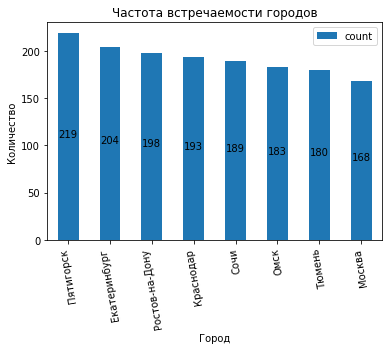

In [16]:
def addlabels(x,y):
    for i in range(len(data_city)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
        
data_city.plot(kind='bar')
addlabels(data_city['count'], data_city['count'])
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество')
plt.xticks(rotation=100)
plt.show()

Чаще всего пользуются сервисом в Пятигорске(219), Екатеринбурге(204) и Ростове-на-Дону(198), меньше всего- в Москве(168). По срезу понятно, что в каждом городе заргеистрировано хотя бы 150 пользователей.

2. Соотношение пользователей с подпиской и без подписки:


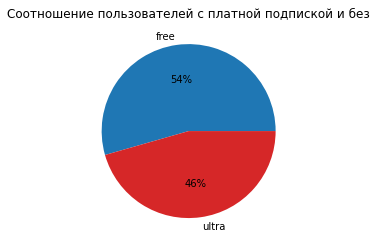

In [18]:
_table = data_users.value_counts('subscription_type')
data, labels = _table.values, _table.index
plt.pie(data, labels=labels, autopct='%.0f%%', colors=['tab:blue', 'tab:red'])
plt.title('Соотношение пользователей с платной подпиской и без')
plt.show()

Как и следовало ожидать, пользователей с бесплатной подпиской больше.

3. Оценим возраст пользователей.


In [19]:
data_users['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43])

Text(0, 0.5, 'Количество')

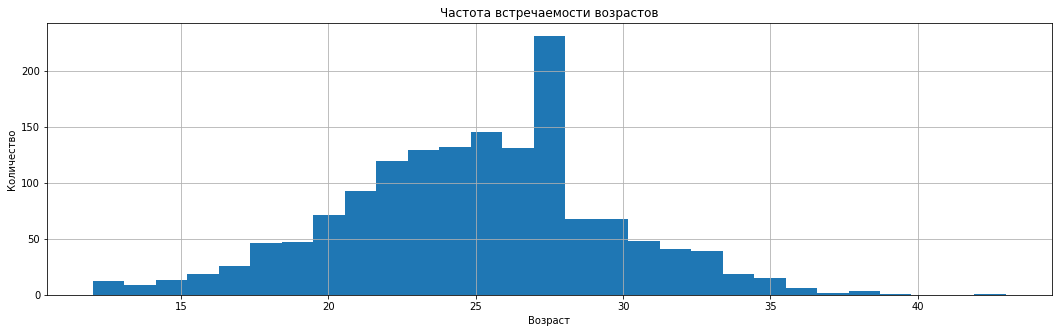

In [20]:
data_users['age'].hist(bins=29,figsize=(18,5))
plt.title('Частота встречаемости возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество')

4. Оценим расстояния, которые преодолевают пользователи за поездку:

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

   <div> Обычно пользуюсь функцией describe(), пропустил в данном случае. Исправляюсь: <a class="tocSkip"> <div>

In [21]:
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

   <div> Подкорректировал вывод: <a class="tocSkip"> <div>

Видим явный пик среди возрастов пользователей-27 лет. В остальном, распределение похоже на нормальное вокруг 25 лет. Самые часто встречающиеся значения находятся в диапазоне от 22 до 28 лет, действительно. Среднее и медиана близки друг к другу, значит, сильно влияющих выбросов нет.

4. Оценим расстояния, которые преодолевают пользователи за поездку:


In [22]:
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Text(0, 0.5, 'Количество')

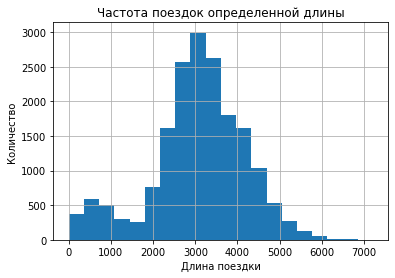

In [23]:
data_rides['distance'].hist(bins = 20)
plt.title('Частота поездок определенной длины')
plt.xlabel('Длина поездки')
plt.ylabel('Количество')

Видно, что в среднем пользователи проезжают 3100-3200 м за поездку. Большая часть поездок находится в промежутке от 2500 до 3800 м. Однако есть и крайне малые значения, так и большие - 7200 м. Распределение похожее на нормальное.

Есть пик в самом начале, связанный возможно с тем, что некоторые люди бросают самокаты по причине того, что им не понравилось или не получилось использовать должным образом.

5. Оценим продолжительность поездок:

In [24]:
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Text(0, 0.5, 'Количество')

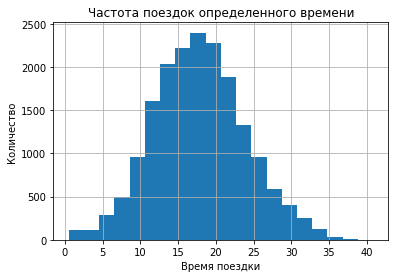

In [25]:
data_rides['duration'].hist(bins = 20)
plt.title('Частота поездок определенного времени')
plt.xlabel('Время поездки')
plt.ylabel('Количество')

БОльшая часть поездок по длительности занимает от 14 до 24 минут. Средняя в районе 18. Однако есть и пики, означающие, возможно, поездки по одним и тем же маршрутам или "групповые" заезды. 

 Проверяем аномально длинные заезды за короткое время:

In [26]:
data_rides.loc[data_rides['duration']<1]


,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Действительно, среди данных есть 95 строк с аномально коротким временем заезда, но большим расстоянием при этом. Выбросы удалить не сможем из-за большого искажения данных. 1/18 это большая часть в нашем случае. 

## <a id='toc4_'></a>Объединение данных [&#8593;](#toc0_)

1. Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [27]:
d1 = data_users.merge(data_rides, on='user_id',how='outer',suffixes=('первый датафрейм','второй датафрейм'))
d1

,index,user_id,name,age,city,subscription_type,distance,duration,date,month
0,0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,0,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,0,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,0,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,0,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...,...
18063,1533,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1533,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1533,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1533,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [28]:
data_all = data_subscriptions.merge(d1,on='subscription_type',how='outer')
data_all

,subscription_type,minute_price,start_ride_price,subscription_fee,index,user_id,name,age,city,distance,duration,date,month
0,free,8,50,0,699,700,Айдар,22,Омск,2515.690719,14.944286,2021-01-02,1
1,free,8,50,0,699,700,Айдар,22,Омск,846.932642,16.234663,2021-02-01,2
2,free,8,50,0,699,700,Айдар,22,Омск,4004.434142,20.016628,2021-02-04,2
3,free,8,50,0,699,700,Айдар,22,Омск,1205.911290,9.782872,2021-02-10,2
4,free,8,50,0,699,700,Айдар,22,Омск,3047.379435,17.427673,2021-02-14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,ultra,6,0,199,698,699,Оксана,22,Москва,3973.046497,24.671163,2021-08-29,8
18064,ultra,6,0,199,698,699,Оксана,22,Москва,3288.702563,15.892886,2021-09-12,9
18065,ultra,6,0,199,698,699,Оксана,22,Москва,3076.159348,14.389525,2021-09-26,9
18066,ultra,6,0,199,698,699,Оксана,22,Москва,4707.845501,15.839579,2021-10-17,10


Убедимся, что данные не потеряны и не появилось ли новых строк. Исследуем новый датафрейм на пропуски. 

In [29]:
data_all.shape

(18068, 13)

In [30]:
data_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   subscription_type  18068 non-null  object        
 1   minute_price       18068 non-null  int64         
 2   start_ride_price   18068 non-null  int64         
 3   subscription_fee   18068 non-null  int64         
 4   index              18068 non-null  int64         
 5   user_id            18068 non-null  int64         
 6   name               18068 non-null  object        
 7   age                18068 non-null  int64         
 8   city               18068 non-null  object        
 9   distance           18068 non-null  float64       
 10  duration           18068 non-null  float64       
 11  date               18068 non-null  datetime64[ns]
 12  month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(3)
memory 

In [31]:
data_all.duplicated().sum()

0

Данные полностью корректны.

2. Создадим 2 датафрейма с данными о пользователях с подпиской и без подписки:

In [32]:
data_ultra = data_all.loc[data_all['subscription_type']=='ultra']
data_ultra

,subscription_type,minute_price,start_ride_price,subscription_fee,index,user_id,name,age,city,distance,duration,date,month
11568,ultra,6,0,199,0,1,Кира,22,Тюмень,4409.919140,25.599769,2021-01-01,1
11569,ultra,6,0,199,0,1,Кира,22,Тюмень,2617.592153,15.816871,2021-01-18,1
11570,ultra,6,0,199,0,1,Кира,22,Тюмень,754.159807,6.232113,2021-04-20,4
11571,ultra,6,0,199,0,1,Кира,22,Тюмень,2694.783254,18.511000,2021-08-11,8
11572,ultra,6,0,199,0,1,Кира,22,Тюмень,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,ultra,6,0,199,698,699,Оксана,22,Москва,3973.046497,24.671163,2021-08-29,8
18064,ultra,6,0,199,698,699,Оксана,22,Москва,3288.702563,15.892886,2021-09-12,9
18065,ultra,6,0,199,698,699,Оксана,22,Москва,3076.159348,14.389525,2021-09-26,9
18066,ultra,6,0,199,698,699,Оксана,22,Москва,4707.845501,15.839579,2021-10-17,10


In [33]:
data_free = data_all.loc[data_all['subscription_type']=='free']
data_free

,subscription_type,minute_price,start_ride_price,subscription_fee,index,user_id,name,age,city,distance,duration,date,month
0,free,8,50,0,699,700,Айдар,22,Омск,2515.690719,14.944286,2021-01-02,1
1,free,8,50,0,699,700,Айдар,22,Омск,846.932642,16.234663,2021-02-01,2
2,free,8,50,0,699,700,Айдар,22,Омск,4004.434142,20.016628,2021-02-04,2
3,free,8,50,0,699,700,Айдар,22,Омск,1205.911290,9.782872,2021-02-10,2
4,free,8,50,0,699,700,Айдар,22,Омск,3047.379435,17.427673,2021-02-14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,free,8,50,0,1533,1534,Альберт,25,Краснодар,3781.098080,19.822962,2021-11-04,11
11564,free,8,50,0,1533,1534,Альберт,25,Краснодар,2840.423057,21.409799,2021-11-16,11
11565,free,8,50,0,1533,1534,Альберт,25,Краснодар,3826.185507,18.435051,2021-11-18,11
11566,free,8,50,0,1533,1534,Альберт,25,Краснодар,2902.308661,16.674362,2021-11-27,11


 Проверим, правильно ли разделились датафреймы:

3. Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [36]:
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [37]:
data_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

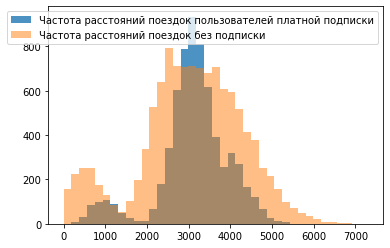

In [38]:
from matplotlib import pyplot
x = [data_ultra['distance']]
y = [data_free['distance']]

bins = np.linspace(0, 7300 , 40)

pyplot.hist(x, bins, alpha=0.8, label='Частота расстояний поездок пользователей платной подписки')
pyplot.hist(y, bins, alpha=0.5, label='Частота расстояний поездок без подписки')
pyplot.legend(loc='upper right')
pyplot.show()


Форма графиков похожа, просто пользователей бесплатной подписки больше, вследствие чего и частота конкретных значений больше.
У пользователей бесплатной подписки среднее значений длины поездки сильнее отличается от медианы, нежели у пользователей с платной подпиской, в связи с наличием очень длинных поездок-выбросов.
Больший разброс длин поездок исходя из стандартного отклонения также у пользователей бесплатной подписки.

В распределении средней дистанции поездок больше четких пиков. Возможно конкретные поездки конкретных людей.

In [42]:
data_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [43]:
data_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

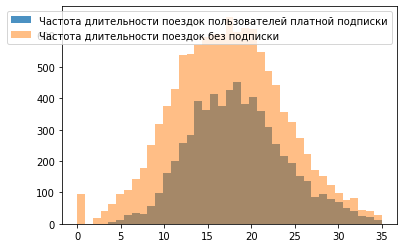

In [44]:
x = [data_ultra['duration']]
y = [data_free['duration']]

bins = np.linspace(0, 35 , 40)

pyplot.hist(x, bins, alpha=0.8, label='Частота длительности поездок пользователей платной подписки')
pyplot.hist(y, bins, alpha=0.5, label='Частота длительности поездок без подписки')
pyplot.legend(loc='upper right')
pyplot.show()

По длительности поездок:

Больший разброс значений длительности опять же у пользователей бесплатной подписки. Здесь так же видна аномалия данных в виде маленького количества времени конкретных поездок. Длительность поездок у пользователей платной подписки в среднем больше.  Графики визуально похожи с намеком на нормальное распределение. 


## <a id='toc5_'></a>Подсчет выручки [&#8593;](#toc0_)

1. Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными.

In [45]:
data_all['duration'] = np.ceil(data_all['duration']) # Округлим данные о длительности поездки до целого числа
data_categorize = data_all.pivot_table(index=['user_id','month'],values=['distance','duration'], aggfunc=['count','sum']) #группировка данных о каждом пользователе помесячно
data_categorize.columns = ['distance_count','rides_count','total_distance','total_duration']#Переименование столбцов
data_categorize.drop('distance_count', axis= 1 , inplace= True )#удаление лишнего столбца
data_categorize = pd.merge(
    left=data_categorize,
    right=data_all
        .groupby('user_id')[['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']]
        .agg('first'),
    left_index=True,
    right_index=True
)
data_categorize.head(20)

rides_count  total_distance  total_duration subscription_type  \
user_id month                                                                  
1       1                2     7027.511294            42.0             ultra   
        4                1      754.159807             7.0             ultra   
        8                2     6723.470560            46.0             ultra   
        10               2     5809.911100            32.0             ultra   
        11               3     7003.499363            56.0             ultra   
        12               2     6751.629942            28.0             ultra   
2       3                3    10187.723006            63.0             ultra   
        4                2     6164.381824            40.0             ultra   
        6                1     3255.338202            14.0             ultra   
        7                2     6780.722964            48.0             ultra   
        8                1      923.007439             7.0             ultra   
        10               1     2824.636598            19.0             ultra   
        12               1     3828.248580            12.0             ultra   
3       1                1     3061.777147            13.0             ultra   
        2                2     5421.152016            39.0             ultra   
        4                1     2956.651632            21.0             ultra   
        5                3     9064.026918            63.0             ultra   
        7                3    10919.595403            67.0             ultra   
        9                1     2891.012822            23.0             ultra   
        12               1     2593.381928            13.0             ultra   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199  
        12                6                 0               199  
2       3                 6                 0               199  
        4                 6                 0               199  
        6                 6                 0               199  
        7                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        12                6                 0               199  
3       1                 6                 0               199  
        2                 6                 0               199  
        4                 6                 0               199  
        5                 6                 0               199  
        7                 6                 0               199  
        9                 6                 0               199  
        12                6                 0               199

2. Добавим в этот датафрейм выручку по каждому пользователю.

In [46]:
def total_revenue(d: pd.Series):
    return  d['subscription_fee'] + d['start_ride_price'] * d['rides_count'] + d['minute_price'] * d['total_duration']

In [47]:
data_categorize['revenue'] = data_categorize.apply(total_revenue, axis=1)
data_categorize.head(20)

rides_count  total_distance  total_duration subscription_type  \
user_id month                                                                  
1       1                2     7027.511294            42.0             ultra   
        4                1      754.159807             7.0             ultra   
        8                2     6723.470560            46.0             ultra   
        10               2     5809.911100            32.0             ultra   
        11               3     7003.499363            56.0             ultra   
        12               2     6751.629942            28.0             ultra   
2       3                3    10187.723006            63.0             ultra   
        4                2     6164.381824            40.0             ultra   
        6                1     3255.338202            14.0             ultra   
        7                2     6780.722964            48.0             ultra   
        8                1      923.007439             7.0             ultra   
        10               1     2824.636598            19.0             ultra   
        12               1     3828.248580            12.0             ultra   
3       1                1     3061.777147            13.0             ultra   
        2                2     5421.152016            39.0             ultra   
        4                1     2956.651632            21.0             ultra   
        5                3     9064.026918            63.0             ultra   
        7                3    10919.595403            67.0             ultra   
        9                1     2891.012822            23.0             ultra   
        12               1     2593.381928            13.0             ultra   

               minute_price  start_ride_price  subscription_fee  revenue  
user_id month                                                             
1       1                 6                 0               199    451.0  
        4                 6                 0               199    241.0  
        8                 6                 0               199    475.0  
        10                6                 0               199    391.0  
        11                6                 0               199    535.0  
        12                6                 0               199    367.0  
2       3                 6                 0               199    577.0  
        4                 6                 0               199    439.0  
        6                 6                 0               199    283.0  
        7                 6                 0               199    487.0  
        8                 6                 0               199    241.0  
        10                6                 0               199    313.0  
        12                6                 0               199    271.0  
3       1                 6                 0               199    277.0  
        2                 6                 0               199    433.0  
        4                 6                 0               199    325.0  
        5                 6                 0               199    577.0  
        7                 6                 0               199    601.0  
        9                 6                 0               199    337.0  
        12                6                 0               199    277.0

## <a id='toc6_'></a>Проверка гипотез [&#8593;](#toc0_)

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Прежде чем ввести определенные акции, необходимо проверить несколько гипотез:

1. Тратят ли пользователи с подпиской больше времени на поездки?

Для начала сравним средние и медианные значения времени поездок у пользователей с платной подпиской и без. После чего сможем сформулировать гипотезы.

In [48]:
data_free['duration'].agg(['mean', 'median'])

mean      17.390909
median    17.326890
Name: duration, dtype: float64

In [49]:
data_ultra['duration'].agg(['mean', 'median'])

mean      18.541985
median    18.178153
Name: duration, dtype: float64

С первого взгляда, можно предположить, что пользователи с платной подпиской действительно тратят больше времени на поездки.

Сформулируем гипотезы так:

 $H_0$ - Средняя длительность поездки у пользователей с подпиской и без равны.
 
 $H_1$ - Средняя длительность поездки у пользователей с подпиской больше,чем у пользователей без подписки.

In [50]:
alpha = 0.05 # задаём уровень значимости

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, можем полагать, что продолжительность поездок с платной подпиской выше, чем у пользователей без подписки. Видно, что поменяв, уровень значимости до 0.01 гипотеза так же была бы отвергнута.

2. Оптимальное расстояние одной поездки 3130м. Совпадает ли с действительностью у пользователей с подпиской?

In [51]:
data_ultra['distance'].agg(['mean', 'median'])

mean      3115.445388
median    3148.637229
Name: distance, dtype: float64

Сформулируем гипотезы так:

 $H_0$ - Среднее расстояние одной поездки у пользователей с платной подпиской равно 3130м.
 
 $H_1$ - Среднее расстояние одной поездки у пользователей с платной подпиской больше 3130м.

In [52]:
alpha = 0.05 # задаём уровень значимости

results = st.ttest_1samp(data_ultra['distance'], 3130, alternative='greater')# проводим ttest , в качестве альтернативной используем одностороннюю гипотезу «больше»

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


Как итог, можно с высокой долей уверенности считать, что среднее расстояние одной поездки у пользователей с подпиской примерно равно 3130м.  

3. Помесячная выручка от пользователей с подпиской выше аналогичной у пользователей без подписки?

In [53]:
print(data_categorize['revenue'].loc[data_categorize['subscription_type']=='ultra'].mean())
print(data_categorize['revenue'].loc[data_categorize['subscription_type']=='free'].mean())

362.7921906022502
328.6413651073845


Сформулируем гипотезы:

$H_0$ - Средняя помесячная выручка от пользователей с подпиской и без равны.  
$H_1$ - Средняя помесячная выручка от пользователей с подпиской больше

In [54]:
alpha = 0.05 # задаём уровень значимости

results = st.ttest_ind(data_categorize['revenue'].loc[data_categorize['subscription_type']=='ultra'],data_categorize['revenue'].loc[data_categorize['subscription_type']=='free'], alternative='greater')# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Так как нулевая гипотеза отвергнута, значит средняя помесячная выручка от пользователей с подпиской все-таки больше.

4. Количество обращений до и после обновления приложения.


Подойдет двухвыборочный t-тест для зависимых выборок "до" обновления и "после" с односторонней гипотезой. Он доступен к применению кодом: `scipy.stats.ttest_rel`.
Гипотезы могли бы быть сформулированы так:

$H_0$ - Количество обращений "до" и "после" обновления одинаковое.

$H_1$ - Количество обращений "после" обновления меньше того, что было "до" обновления.

Пример кода:



In [55]:

#alpha = 0.05

#results = st.ttest_rel(after, before, alternative='less')

#print(f'p-value: {results.pvalue}')

#if results.pvalue < alpha:
#    print('Отвергаем нулевую гипотезу')
#else:
#    print('Нет оснований отвергнуть нулевую гипотезу')

<div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

   <div> Исправил <a class="tocSkip"> <div>

## <a id='toc7_'></a>Общий вывод [&#8593;](#toc0_)

В рамках данного исследования были пройдены такие этапы:

1. Загрузка и предобработка данных.
Были загружены 3 датасета, проведена предобработка каждого из них, в частности: обработка пропусков, а также обнаружение явных и неявных дубликатов.

2. Исследовательский анализ данных
На данном этапе мы произвели исследование и визуализацию данных в таких столбцах: города, тип подписки пользователей, возраст пользователей, расстояние одной поездки и продолжительность поездок. Из характерного: 
- Было выяснено, что наиболее популярный город - Пятигорск, наименее популярный - Москва.
- Пользователей с бесплатной подпиской больше, чем пользователей с платной подпиской.
- Возраст пользователей определяется почти нормальным распределением со средним~25 лет. Основная возрастная группа от 15 до 35 лет.
- Относительно расстояний одной поездки: Самая короткая поездка длиной чуть меньше метра, самая длинная- 7211м. Среднее значение длины, как было выяснено, находится около 3100м ( чуть позже это число определили точнее -3130м).
- По времени одной поездки: диапазон значений от 0,5 минуты до 41 минуты. Средняя длительность поездки около 18 минут, бОльшая часть поездок в диапазоне от 5 до 30 минут.

3. Следующим пунктом мы объединили датафреймы для дальнейшего пользования и получили два дополнительных с пользователями бесплатной подписки и пользователями платной подписки. Получили некоторые выводы относительно данных категорий:

- У пользователей бесплатной подписки среднее значений длины поездки сильнее отличается от медианы, нежели у пользователей с платной подпиской, в связи с наличием очень длинных поездок-выбросов.Больший разброс длин поездок исходя из стандартного отклонения также у пользователей бесплатной подписки. Длины поездок распределены почти нормальным образом.

- Больший разброс значений длительности опять же у пользователей бесплатной подписки. Здесь так же видна аномалия данных в виде маленького количества времени конкретных поездок. Длительность поездок у пользователей платной подписки в среднем больше. Распредления длительностей поездок также близки к нормальным. 


4. Была подсчитана помесячная выручка для каждого пользователя.

5. В ходе проверки гипотез, были сделаны такие выводы:

- Продолжительность поездок у пользователей с подпиской больше, нежели у пользователей без подписки(отвергунта нулевая гипотеза)
- Среднее расстояние одной поездки для пользователей с подпиской примерно равно 3130 метров (нулевая гипотеза не отвергнута)
- Выручка от пользователей c подпиской выше, нежели от пользователей без подписки( нулевая гипотеза отвергнута).

6. Были решены некоторые статистические задачи для помощи в возможных улучшениях бизнеса.

Характерным выводом для бизнеса будет факт, что пользователи с платной подпиской так или иначе выгоднее для данного бизнеса. Поэтому стоит направить усилия специалистов в русло привлечения пользователей в категорию *ultra*.